### Using list

In [1]:
%cd /home/ltchen/gnnpp
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils import to_networkx
from scipy.interpolate import interp1d
from utils.data import load_dataframes, load_distances, load_stations, dist_km, compute_dist_matrix, normalize_features_and_create_graphs, split_graph, shuffle_features, summary_statistics, get_mask, generate_layers, create_multigraph
from tqdm import tqdm
from utils.plot import plot_map
from torch_geometric.utils import is_undirected, degree, contains_isolated_nodes

/home/ltchen/gnnpp


#### Functions

In [2]:
def signed_difference(x, y): # macht es Sinn signed difference zu benutzen?
    return x - y

def dist_km(lat1: float = 0, lon1: float = 0, lat2: float = 0, lon2: float = 0) -> float:
    return geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km

def signed_geodesic_km(lat1: float = 0, lon1: float = 0, lat2: float = 0, lon2: float = 0) -> float:
    if lat1 > lat2 or lon1 > lon2:
        dist = geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km
    else:
        dist = -1 * geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km
    return dist

def create_emp_cdf(station_temps):  # F_i(x)
    data_sorted = np.sort(station_temps)
    cdf = np.arange(len(data_sorted)) / len(data_sorted)
    cdf_function = interp1d(data_sorted, cdf, kind='previous', bounds_error=False, fill_value=(0, 1))
    return cdf_function

def dist2(i_id, j_id, train_set):
# def dist2(i_id, j_id):
    # print(i_id, j_id)
    i_train_temps = train_set[train_set['station_id'] == i_id]['t2m']
    j_train_temps = train_set[train_set['station_id'] == j_id]['t2m']
    F_i = create_emp_cdf(i_train_temps)
    F_j = create_emp_cdf(j_train_temps)
    sum = 0
    S = np.arange(train_set['t2m'].min(), train_set['t2m'].max(), 1)
    for x in S:
        sum += abs(F_i(x) - F_j(x))
    d2 = sum * 1/S.shape[0]
    return d2

# def compute_d2_matrix(stations: pd.DataFrame, df: pd.DataFrame) -> np.array:
    # macht es Sinn, dass trainset hier hinzugegeben wird fuer die graphenerstellung?
def compute_d2_matrix(stations: pd.DataFrame, train_set: pd.DataFrame) -> np.array: # nochmal checken ob die funktion noch funktionert!!
    station_id = np.array(stations.index).reshape(-1, 1)
    # print(station_id.shape)
    # print(station_id.T.shape)
    vectorized_dist2 = np.vectorize(dist2, excluded=[2])
    distance_matrix = vectorized_dist2(station_id, station_id.T, train_set)
    # distance_matrix = np.vectorize(dist2)(station_id, station_id.T)
    return distance_matrix

def load_d2_distances(stations: pd.DataFrame, train_set: pd.DataFrame) -> np.ndarray:
    if os.path.exists("/mnt/sda/Data2/gnnpp-data/d2_distances_EUPP.npy"):
        print("[INFO] Loading distances from file...")
        mat = np.load("/mnt/sda/Data2/gnnpp-data/d2_distances_EUPP.npy")
    else:
        print("[INFO] Computing distances...")
        mat = compute_d2_matrix(stations, train_set)
        np.save("/mnt/sda/Data2/gnnpp-data/d2_distances_EUPP.npy", mat)
    return mat

def create_emp_cdf_of_errors(station_df, target_temp): # cdfs v
    f_bar = station_df.groupby(['time'])['t2m'].mean()
    def cdf_functions(z):
        return (1/ station_df.nunique()['time']) * np.sum(f_bar.to_numpy() - target_temp.to_numpy() <= z)
    return cdf_functions

def dist3(i_id, j_id, cdfs):
    print(i_id, j_id)
    sum = 0
    S = np.arange(-10, 10, 0.5)
    for x in S:
        sum += abs(cdfs[i_id](x) - cdfs[j_id](x))
    d3 = sum * 1/S.shape[0]
    return d3

def compute_d3_matrix(stations: pd.DataFrame, train_set, train_target_set) -> np.array:
    station_id = np.array(stations.index).reshape(-1, 1)
    cdfs = []
    for i_id in range(0, 122):
        i_train = train_set[train_set['station_id'] == i_id]
        i_target_temps = train_target_set[train_target_set['station_id'] == i_id]['t2m']
        G_s = create_emp_cdf_of_errors(i_train, i_target_temps)
        cdfs.append(G_s)
    print("[INFO] Cdfs created.")
    vectorized_dist3 = np.vectorize(dist3, excluded=[2])
    distance_matrix = vectorized_dist3(station_id, station_id.T, cdfs)
    return distance_matrix

def load_d3_distances(stations: pd.DataFrame, train_set, train_target_set) -> np.ndarray:
    if os.path.exists("/mnt/sda/Data2/gnnpp-data/d3_distances_EUPP.npy"):
        print("[INFO] Loading distances from file...")
        mat = np.load("/mnt/sda/Data2/gnnpp-data/d3_distances_EUPP.npy")
    else:
        print("[INFO] Computing distances...")
        mat = compute_d3_matrix(stations, train_set, train_target_set)
        np.save("/mnt/sda/Data2/gnnpp-data/d3_distances_EUPP.npy", mat)
    return mat

def load_d4_distances(stations: pd.DataFrame, train_set, train_target_set) -> np.ndarray:
    mat_d2 = load_d2_distances(stations)
    mat_d3 = load_d3_distances(stations, train_set, train_target_set)
    mat = mat_d2 + mat_d3
    return mat

def compute_mat(station_df: pd.DataFrame, mode: str, train_set: pd.DataFrame = None, train_target_set: pd.DataFrame = None) -> np.array:
    if mode == "geo":
        lon = np.array(station_df["lon"].copy())
        lat = np.array(station_df["lat"].copy())
        lon_mesh, lat_mesh = np.meshgrid(lon, lat)
        distance_matrix = np.vectorize(dist_km)(lat_mesh, lon_mesh, lat_mesh.T, lon_mesh.T)
    if mode == "alt":
        altitude = np.array(station_df["altitude"].copy())
        mesh1, mesh2 = np.meshgrid(altitude, altitude)
        distance_matrix = np.vectorize(signed_difference)(mesh1, mesh2) # zwei vektoren voneinander abziehen
    if mode == "alt-orog":
        altorog = np.array((station_df['altitude']-station_df['orog']).copy())
        mesh1, mesh2 = np.meshgrid(altorog, altorog)
        distance_matrix = np.vectorize(signed_difference)(mesh1, mesh2)
    if mode == "lon":
        lon = np.array(station_df["lon"].copy())
        mesh1, mesh2 = np.meshgrid(lon, lon)
        distance_matrix = np.vectorize(signed_geodesic_km)(lon1 =mesh1, lon2=mesh2)
    if mode == "lat":
        lat = np.array(station_df["lat"].copy())
        mesh1, mesh2 = np.meshgrid(lat, lat) # check if this meshgrid actually works!!
        distance_matrix = np.vectorize(signed_geodesic_km)(lat1=mesh1, lat2=mesh2) # vorzeichen!
    if mode == "dist2":
        distance_matrix = load_d2_distances(station_df, train_set)
    if mode == "dist3":
        distance_matrix = load_d3_distances(station_df, train_set, train_target_set)
    if mode == "dist4":
        distance_matrix = load_d4_distances(station_df, train_set, train_target_set)
    return distance_matrix

def get_adj(dist_matrix_sliced: np.array, max_dist: float = 50) -> np.array:
    mask = None
    mask = (dist_matrix_sliced <= max_dist) & (dist_matrix_sliced >= (-max_dist))
    diagonal = np.full((mask.shape[0], mask.shape[1]), True, dtype=bool)
    np.fill_diagonal(diagonal, False)
    mask = np.logical_and(mask, diagonal)
    return mask

#### Graph creation function

In [3]:
def create_graph_data(
        df_train: Tuple[pd.DataFrame],
        date: str,
        ensemble: int,
        sum_stats: bool = False):
    day = df_train[0][df_train[0].time == date]
    if sum_stats:
        ens = day #?
    else:
        ens = day[day.number == ensemble] # only if sum_stats = False

    ens = ens.drop(columns=["time", "number"])
    x = torch.tensor(ens.to_numpy(dtype=np.float32))
    df_target = df_train[1]

    target = df_target[df_target.time == date] # wo kommt df_target her??
    target = target.drop(columns=["time", "station_id"]).to_numpy()
    y = torch.tensor(target)

    lon = ens["station_longitude"].to_numpy().reshape(-1, 1)
    # print(lon.shape)
    lat = ens["station_latitude"].to_numpy().reshape(-1, 1)
    # print(lat.shape)
    position = np.concatenate([lon, lat], axis=1).reshape(-1, 2)
    # print(position.shape)
    # pos_dict = dict(enumerate(position))

    return x, y, position

In [43]:
!!#ADJUSTED!!!
def create_graph_dataset(df_train: pd.DataFrame, df_target: pd.DataFrame, station_df: pd.DataFrame, attributes: list, edges: list, ensemble: int, sum_stats: bool = False):
    assert (not ((ensemble == None) and (sum_stats == False))), "Input either ensemble member number or sum_stats=True"

    # assert all elements in edges exist in attributes!
    first_el = [t[0] for t in edges]
    assert set(attributes).issuperset(set(first_el)), "Edges must be created based on attributes that exist."

    # attribute tensor creation
    t_dim = len(attributes)
    attr_tensor = torch.empty((122, 122, t_dim), dtype=torch.float32)
    for i, list_element in enumerate(attributes):
        # compute distance matrix
        attr_tensor[:,:,i] = torch.tensor(compute_mat(station_df, list_element))

    attr_mask = torch.empty(122, 122, len(edges))
    for i, el in enumerate(edges):
        attr, max_value = el
        # position von attr in der attribute liste => welche distance matrix in tensor
        pos = attributes.index(attr)
        attr_mask[:,:,i] = get_adj(attr_tensor[:, :, pos], max_dist=max_value)

    g_adj = attr_mask.any(dim=2)
    g_edges = np.array(np.argwhere(g_adj))
    g_edge_idx = torch.tensor(g_edges.T)
    g_edge_attr = attr_tensor[g_adj]

    # standardization
    max_edge_attr = g_edge_attr.max(dim=0).values
    std_g_edge_attr = g_edge_attr / max_edge_attr

    n_nodes = len(df_train.station_id.unique())
    n_fc = len(df_train.number.unique())

    graphs = []
    for time in tqdm(df_train.time.unique()):
        x, y, position = create_graph_data((df_train, df_target), time, ensemble, sum_stats) # date raus!
        graph = Data(x=x, edge_index=g_edge_idx.T, edge_attr=std_g_edge_attr, timestamp=time, y=y, pos=position, n_idx=torch.arange(n_nodes).repeat(n_fc))
        graphs.append(graph)

    return graphs

def normalize_features(data: List[Tuple[pd.DataFrame]]):
    print("[INFO] Normalizing features...")
    train_rf = data[0][0]
    features_to_normalize = [col for col in train_rf.columns if col not in ["station_id", "time", "number"]]

    # Create a MinMaxScaler object
    scaler = StandardScaler()

    # Fit and transform the selected features
    for i, (features, targets) in enumerate(data):
        if i == 0:
            features.loc[:, features_to_normalize] = scaler.fit_transform(features[features_to_normalize]).astype("float32")
            print("fit_transform")
        else:

            features.loc[:, features_to_normalize] = scaler.transform(features[features_to_normalize]).astype("float32")
            print(f"transform {i}")
        features.loc[:, ["cos_doy"]] = np.cos(2 * np.pi * features["time"].dt.dayofyear / 365)
        features.loc[:, ["sin_doy"]] = np.sin(2 * np.pi * features["time"].dt.dayofyear / 365)
    return data

def temp_conversion(data: List[Tuple[pd.DataFrame]]):
    print("[INFO] Converting temperature values...")
    for _, targets in data:
        targets.loc[:, ["t2m"]] = targets.loc[:, ["t2m"]] - 273.15
    return data

In [41]:
def create_one_graph(df_train: pd.DataFrame, df_target: pd.DataFrame, station_df: pd.DataFrame, attributes: list, edges: list, date: str, ensemble: int, sum_stats: bool = False):
    '''
    FOR PLOTTING
    '''
    x, y, position = create_graph_data((df_train, df_target), date, ensemble, sum_stats)
    # assert all elements in edges exist in attributes!
    first_el = [t[0] for t in edges]
    assert set(attributes).issuperset(set(first_el)), "Edges must be created based on attributes that exist."

    # attribute tensor creation
    t_dim = len(attributes)
    attr_tensor = torch.empty((122, 122, t_dim), dtype=torch.float32)
    for i, list_element in enumerate(attributes):
        # compute distance matrix
        attr_tensor[:,:,i] = torch.tensor(compute_mat(station_df, list_element))

    attr_mask = torch.empty(122, 122, len(edges))
    for i, el in enumerate(edges):
        attr, max_value = el
        # position von attr in der attribute liste => welche distance matrix in tensor
        pos = attributes.index(attr)
        attr_mask[:,:,i] = get_adj(attr_tensor[:, :, pos], max_dist=max_value)

    g_adj = attr_mask.any(dim=2)
    g_edges = np.array(np.argwhere(g_adj))
    g_edge_idx = torch.tensor(g_edges.T)
    g_edge_attr = attr_tensor[g_adj]

    # standardization
    max_edge_attr = g_edge_attr.max(dim=0).values
    std_g_edge_attr = g_edge_attr / max_edge_attr

    n_nodes = len(df_train.station_id.unique())
    n_fc = len(df_train.number.unique())

    graph = Data(x=x, edge_index=g_edge_idx.T, edge_attr=std_g_edge_attr, timestamp=date, y=y, pos=position, n_idx=torch.arange(n_nodes).repeat(n_fc))
    return graph

In [26]:
! #ADJUSTED
def normalize_features_and_create_graphs1(df_train: Tuple[pd.DataFrame], df_valid_test: List[Tuple[pd.DataFrame]], station_df: pd.DataFrame, attributes: list, edges: list, ensemble: int=None, sum_stats: bool = False):

    list = [df_train] + df_valid_test
    list = normalize_features(list)
    dfs = temp_conversion(list)
    # print(type(dfs))
    test_valid = []
    for i, (features, targets) in enumerate(dfs):
        if i == 0:
            graphs_train_rf = create_graph_dataset(df_train=features, df_target=targets, station_df=station_df, attributes=attributes, edges=edges, ensemble = ensemble, sum_stats=sum_stats)

        else:
            graphs_valid_test = create_graph_dataset(df_train=features, df_target=targets, station_df=station_df, attributes=attributes, edges=edges, ensemble = ensemble, sum_stats=sum_stats)
            test_valid.append(graphs_valid_test)
    return graphs_train_rf, test_valid

In [34]:
dataframes = load_dataframes(mode="train", leadtime="24h")
stations = dataframes["stations"]
df_target = dataframes['train'][1]
dataframes = summary_statistics(dataframes)


[INFO] Dataframes exist. Will load pandas dataframes.


In [13]:
print(type([dataframes['test_rf'], dataframes['test_f']]))
print(type([dataframes['train']] + [dataframes['test_rf'], dataframes['test_f']]))
data = [dataframes['train']] + [dataframes['test_rf'], dataframes['test_f']]
for i, (features, targets) in enumerate(data):
        print(type(features)) # pd.DataFrame?
        print(targets)

<class 'list'>
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
             time  station_id     t2m
0      1997-01-02           0  277.75
1      1997-01-02           1  279.55
2      1997-01-02           2  276.45
3      1997-01-02           3  275.75
4      1997-01-02           4  279.35
...           ...         ...     ...
420651 2013-12-31         117  281.35
420652 2013-12-31         118  279.35
420653 2013-12-31         119  278.25
420654 2013-12-31         120  273.15
420655 2013-12-31         121  272.65

[420656 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
            time  station_id     t2m
0     2014-01-01           0  279.35
1     2014-01-01           1  279.55
2     2014-01-01           2  277.85
3     2014-01-01           3  277.25
4     2014-01-01           4  279.35
...          ...         ...     ...
89299 2017-12-31         117  280.65
89300 2017-12-31         118  275.75
89301 2017-12-31         119  284.65
89302 2017-12-31         120  278.05
8930

In [45]:
train, test_valid = normalize_features_and_create_graphs1(df_train=dataframes['train'], df_valid_test=[dataframes['test_rf'], dataframes['test_f']], station_df=dataframes['stations'], attributes=["geo", "alt", "lon", "lat", "dist2"], edges=[("geo", 100)], sum_stats = True)

[INFO] Normalizing features...
fit_transform
transform 1
transform 2
[INFO] Loading distances from file...


100%|██████████| 3448/3448 [00:45<00:00, 76.60it/s]


[INFO] Loading distances from file...


100%|██████████| 732/732 [00:02<00:00, 246.32it/s]


[INFO] Loading distances from file...


100%|██████████| 730/730 [00:09<00:00, 75.22it/s]


In [35]:
test_valid[0][1].n_idx

AttributeError: 'GlobalStorage' object has no attribute 'n_idx'

In [44]:
graphs = create_graph_dataset(dataframes['train'][0], dataframes['train'][1], dataframes['stations'], attributes=["geo", "alt", "lon", "lat", "dist2"], edges=[("geo", 100)], ensemble = 0)


[INFO] Loading distances from file...


100%|██████████| 3448/3448 [00:43<00:00, 79.25it/s]


In [48]:
graphs_valid_test = create_graph_dataset((dataframes['train'][0], dataframes['train'][1]), dataframes['stations'], attributes=["geo", "alt", "lon", "lat", "dist2"], edges=[("geo", 100)], ensemble = 0)

[INFO] Loading distances from file...


100%|██████████| 732/732 [00:02<00:00, 253.62it/s]


In [56]:
list = [dataframes["train"], dataframes['test_rf'], dataframes['test_f']]
new = normalize_features(list)

[INFO] Normalizing features...
fit_transform
transform 1
transform 2


In [81]:
type([dataframes['test_rf'], dataframes['test_f']])

list

In [86]:
train, test_valid = normalize_features_and_create_graphs1(df_train=dataframes['train'], df_valid_test=[dataframes['test_rf'], dataframes['test_f']], station_df=dataframes['stations'], attributes=["geo", "alt", "lon", "lat", "dist2"], edges=[("geo", 100)], ensemble = 0)

[INFO] Normalizing features...
<class 'pandas.core.frame.DataFrame'>
             time  station_id     t2m
0      1997-01-02           0  277.75
1      1997-01-02           1  279.55
2      1997-01-02           2  276.45
3      1997-01-02           3  275.75
4      1997-01-02           4  279.35
...           ...         ...     ...
420651 2013-12-31         117  281.35
420652 2013-12-31         118  279.35
420653 2013-12-31         119  278.25
420654 2013-12-31         120  273.15
420655 2013-12-31         121  272.65

[420656 rows x 3 columns]
fit_transform
<class 'pandas.core.frame.DataFrame'>
            time  station_id     t2m
0     2014-01-01           0  279.35
1     2014-01-01           1  279.55
2     2014-01-01           2  277.85
3     2014-01-01           3  277.25
4     2014-01-01           4  279.35
...          ...         ...     ...
89299 2017-12-31         117  280.65
89300 2017-12-31         118  275.75
89301 2017-12-31         119  284.65
89302 2017-12-31         1

100%|██████████| 3448/3448 [00:43<00:00, 79.46it/s]


[INFO] Loading distances from file...


100%|██████████| 732/732 [00:02<00:00, 254.20it/s]


[INFO] Loading distances from file...


100%|██████████| 730/730 [00:08<00:00, 84.33it/s]


In [93]:
len(test_valid[1])

730

<Figure size 1200x1000 with 0 Axes>

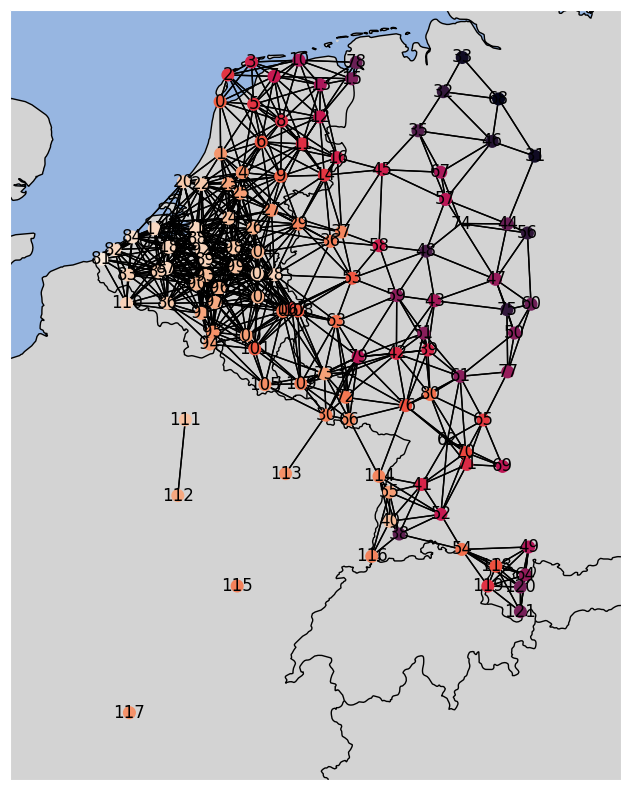

In [30]:
graphs[0].num_edge_features

fig = plt.figure(figsize=(12, 10))
ax = plot_map()
vis = to_networkx(graphs[0])
# nx.draw_networkx(vis, node_size=70, node_color=graph_1.y.numpy(), pos=graph_1.pos, arrows=False, ax=ax)
nx.draw_networkx(vis, node_size=70, node_color=graphs[0].y.numpy(), pos=dict(enumerate(graphs[0].pos)), arrows=False, ax=ax)
plt.show()

[INFO] Loading distances from file...


<Figure size 1200x1000 with 0 Axes>

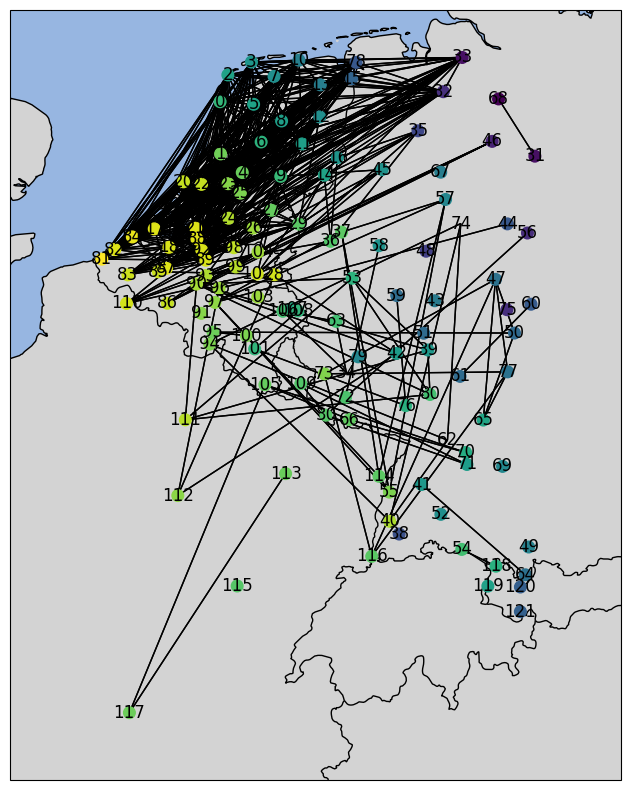

In [35]:
graph_2 = create_one_graph(df_train=dataframes['train'][0], df_target=dataframes['train'][1], station_df=dataframes['stations'],
                           attributes=["geo", "alt", "lon", "lat", "dist2"], edges=[("alt", 10)], date='1997-01-02',
                           ensemble=0)

fig = plt.figure(figsize=(12, 10))
ax = plot_map()
vis = to_networkx(graph_2)
# nx.draw_networkx(vis, node_size=70, node_color=graph_1.y.numpy(), pos=graph_1.pos, arrows=False, ax=ax)
nx.draw_networkx(vis, node_size=70, node_color=graph_2.y.numpy(), pos=dict(enumerate(graph_2.pos)), arrows=False, ax=ax)
plt.show()

In [37]:
graph_2.n_idx.shape

torch.Size([1342])

[INFO] Loading distances from file...


<Figure size 1200x1000 with 0 Axes>

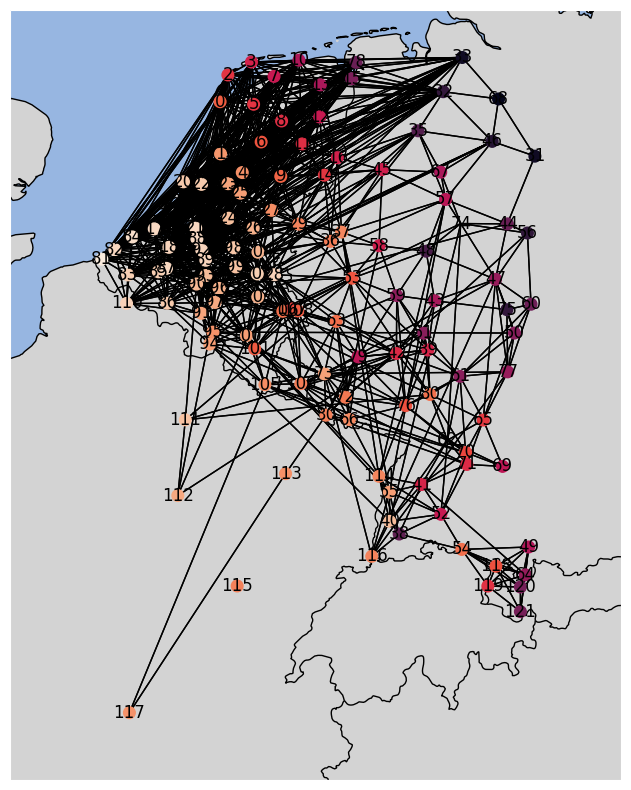

In [40]:
graph_3 = create_one_graph((dfs['train'][0], dfs['train'][1]), dfs['stations'],
                           attributes=["geo", "alt", "lon", "lat", "dist2"], edges=[("geo", 100), ("alt", 10)], date='1997-01-02',
                           ensemble=0)

fig = plt.figure(figsize=(12, 10))
ax = plot_map()
vis = to_networkx(graph_3)
# nx.draw_networkx(vis, node_size=70, node_color=graph_1.y.numpy(), pos=graph_1.pos, arrows=False, ax=ax)
nx.draw_networkx(vis, node_size=70, node_color=graph_3.y.numpy(), pos=dict(enumerate(graph_3.pos)), arrows=False, ax=ax)
plt.show()

In [22]:
pd.DataFrame(graph_2.x)

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.0,-1.706008,1.2,52.928001,4.781000,2.836648,2.531022,0.000000,0.000000,281.971558,...,53159.953125,73.100533,0.001976,0.000711,-6.044947,1.596361,14.901282,2.213271,271.899597,0.644458
1,1.0,-1.298122,-3.3,52.318001,4.790000,2.634943,1.590150,0.000000,0.000000,279.526794,...,53171.109375,69.879578,0.002783,0.000425,-0.290330,4.352897,12.893115,2.602475,272.177216,0.867582
2,2.0,0.333424,10.8,53.241001,4.921000,1.194602,1.639663,0.000000,0.000000,281.728271,...,53191.562500,74.793335,0.001402,0.000607,-6.958210,1.155702,14.182532,2.613971,272.090454,0.679122
3,3.0,1.302155,0.7,53.391998,5.346000,0.735795,1.056404,0.000000,0.000000,281.946930,...,53226.710938,75.694817,0.001034,0.000382,-7.330547,1.031987,12.607337,2.003821,272.252533,0.593362
4,4.0,2.576800,1.9,52.099998,5.180000,2.931818,1.551560,0.000000,0.000000,279.149536,...,53226.003906,68.673775,0.002732,0.000489,0.568068,4.499527,13.118790,2.893250,272.082886,0.684554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,117.0,521.714294,331.0,45.786835,3.149333,1.306818,3.220185,0.000000,0.000000,278.672211,...,54080.203125,32.515301,0.000525,0.000328,11.661729,1.442524,-5.951700,0.881274,271.129517,0.474991
118,118.0,689.253662,424.0,47.499168,9.746111,3.938920,3.634836,0.001456,0.000464,273.700226,...,53705.136719,35.694798,0.001864,0.000237,9.031137,0.913202,-2.843213,1.173958,272.026398,0.370458
119,119.0,972.938721,439.0,47.266666,9.600000,4.366477,3.808742,0.003939,0.001113,273.072601,...,53701.808594,33.547710,0.001849,0.000200,8.719169,0.739527,-3.640976,1.172019,272.192352,0.352554
120,120.0,1752.460815,1478.0,47.255833,10.186111,25.975853,16.039959,0.023536,0.029321,271.711639,...,53697.824219,37.680931,0.002055,0.000124,7.805017,1.034228,-4.744314,0.697626,272.053711,0.354693


In [21]:
dataframes['train'][0][dataframes['train'][0]['time'] == '1997-01-02']

,time,station_id,model_orography,station_altitude,station_latitude,station_longitude,cape_mean,cape_std,sd_mean,sd_std,...,z_std,q_mean,q_std,u_mean,u_std,v_mean,v_std,t_mean,t_std,number
0,1997-01-02,0,-1.706008,1.2,52.928000,4.781000,2.836648,2.531022,0.000000,0.000000,...,73.100531,0.001976,0.000711,-6.044947,1.596361,14.901282,2.213271,271.899597,0.644458,0
1,1997-01-02,1,-1.298122,-3.3,52.318000,4.790000,2.634943,1.590150,0.000000,0.000000,...,69.879574,0.002783,0.000425,-0.290330,4.352897,12.893115,2.602475,272.177216,0.867582,0
2,1997-01-02,2,0.333424,10.8,53.241000,4.921000,1.194602,1.639663,0.000000,0.000000,...,74.793332,0.001402,0.000607,-6.958210,1.155702,14.182532,2.613972,272.090454,0.679122,0
3,1997-01-02,3,1.302155,0.7,53.392000,5.346000,0.735795,1.056404,0.000000,0.000000,...,75.694814,0.001034,0.000382,-7.330547,1.031987,12.607337,2.003821,272.252533,0.593362,0
4,1997-01-02,4,2.576800,1.9,52.100000,5.180000,2.931818,1.551560,0.000000,0.000000,...,68.673778,0.002732,0.000489,0.568068,4.499527,13.118790,2.893250,272.082886,0.684554,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,1997-01-02,117,521.714299,331.0,45.786833,3.149333,1.306818,3.220185,0.000000,0.000000,...,32.515303,0.000525,0.000328,11.661729,1.442524,-5.951700,0.881274,271.129517,0.474991,0
118,1997-01-02,118,689.253673,424.0,47.499168,9.746111,3.938920,3.634836,0.001456,0.000464,...,35.694799,0.001864,0.000237,9.031137,0.913202,-2.843213,1.173958,272.026398,0.370458,0
119,1997-01-02,119,972.938723,439.0,47.266666,9.600000,4.366477,3.808742,0.003939,0.001113,...,33.547709,0.001849,0.000200,8.719169,0.739527,-3.640976,1.172019,272.192352,0.352554,0
120,1997-01-02,120,1752.460782,1478.0,47.255833,10.186111,25.975853,16.039959,0.023536,0.029321,...,37.680931,0.002055,0.000124,7.805017,1.034228,-4.744314,0.697626,272.053711,0.354693,0


### Using Lightning DataModule